In [ ]:
import numpy as np 
import cv2 
import math 
from skimage import io 
from skimage.color import rgb2gray 
import matplotlib.pyplot as plt 
from scipy import signal
%matplotlib inline 

In [ ]:
im1 = cv2.imread('/content/drive/MyDrive/traffic0.png')
im2 = cv2.imread('/content/drive/MyDrive/traffic1.png')
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
kernel_x = np.array([[1., 1.], [1., 1.]])
im2_gray = signal.convolve2d(im2_gray, kernel_x, boundary='symm', mode='same')
im1_gray = signal.convolve2d(im1_gray, kernel_x, boundary='symm', mode='same')


(480, 640)


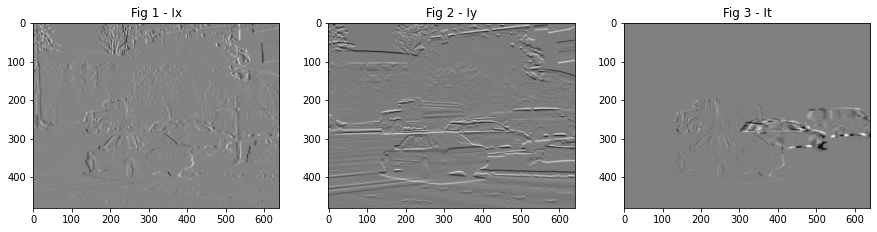

In [ ]:
Ix = cv2.Sobel(im1_gray, cv2.CV_64F,1,0,ksize=3)
Iy = cv2.Sobel(im1_gray, cv2.CV_64F,0,1,ksize=3)
It = (im2_gray - im1_gray)

plt.figure(figsize=(15, 10)) 

plt.subplot(231) 
plt.imshow(Ix, cmap='gray') 
plt.title('Fig 1 - Ix')

plt.subplot(232) 
plt.imshow(Iy, cmap='gray') 
plt.title('Fig 2 - Iy')

plt.subplot(233)
plt.imshow(It, cmap='gray') 
plt.title('Fig 3 - It')

print(im1_gray.shape)

In [ ]:
def lucas_Kanade(Ix, Iy, It, patch_size): 
  u = np.zeros(im1_gray.shape) 
  v = np.zeros(im1_gray.shape) 
  for i in range(patch_size, im1_gray.shape[0]-patch_size): 
    for j in range(patch_size, im1_gray.shape[1]-patch_size): 
      ix = Ix[i-patch_size : i + patch_size + 1, j - patch_size : j + patch_size + 1].flatten() 
      iy = Iy[i-patch_size : i + patch_size + 1, j - patch_size : j + patch_size + 1].flatten() 
      it = -(It[i-patch_size : i + patch_size + 1, j - patch_size : j + patch_size + 1].flatten())
      A = np.vstack((ix, -iy)).T
      res = np.linalg.lstsq(A, it)[0]
      u[i, j]= res[0]
      v[i, j]= res[1] 
  
  return u, v 
patch_size = 35
u,v = lucas_Kanade(Ix,Iy,It,patch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
def horn_Schunck(x_grad, y_grad, temp_deriv, shape, gamma):

    u = np.zeros(shape)
    v = np.zeros(shape)
    u_bar = np.zeros(shape)
    v_bar = np.zeros(shape)
    Ix = x_grad
    Iy = -y_grad
    It = temp_deriv
    Ed = np.zeros(shape)
    Es = np.zeros(shape)
   
    iter = 0
    iterations = 100        
    cur_cost = 0
    prev_cost = float('inf')
    not_converged = True

    while iter < iterations:
        iter += 1
        print(iter)
        for i in range(1,shape[0]-1):
            for j in range(1, shape[1]-1):
                u_bar[i,j] = (u[i+1,j] + u[i-1,j] + u[i,j+1]+ u[i,j-1])/4
                v_bar[i,j] = (v[i+1,j] + v[i-1,j] + v[i,j+1]+ v[i,j-1])/4

                u[i,j] = u_bar[i,j] -  (Ix[i,j]*(Ix[i,j]*u_bar[i,j] + Iy[i,j]*v_bar[i,j] + It[i,j]))/(gamma**2 +Ix[i,j]**2 + Iy[i,j]**2)
                v[i,j] = v_bar[i,j] -  (Iy[i,j]*(Ix[i,j]*u_bar[i,j] + Iy[i,j]*v_bar[i,j] + It[i,j]))/(gamma**2 +Ix[i,j]**2 + Iy[i,j]**2)

                Ed[i,j] = (Ix[i,j]*u_bar[i,j] + Iy[i,j]*v_bar[i,j] + It[i,j])**2
                Es[i,j] = ((u[i,j]-u[i+1,j])**2 +(u[i,j]-u[i,j+1])**2 + (v[i,j]-v[i+1,j])**2 +(v[i,j]-v[i,j+1])**2)/4

        cur_cost = (Ed + gamma*Es).sum()
  
        if prev_cost - cur_cost < 0.01:
            not_converged = False
        
        prev_cost = cur_cost
                
    return u,v

In [ ]:
print(u.shape)
print(Ix.shape)

(200, 200)
(200, 200)


In [ ]:
# Subsample the vector field to make it less dense
gamma = 20
u,v = horn_Schunck(Ix,Iy,It,im1_gray.shape,gamma)

subsample = 6
rows = im1_gray.shape[0]
cols = im1_gray.shape[1]
sub_u = u[0:rows:subsample, 0:cols:subsample]
sub_v = v[0:rows:subsample, 0:cols:subsample]
xc = np.linspace(1, cols-1, sub_u.shape[1])
yc = np.linspace(1, rows-1, sub_u.shape[0])

# Locations of the vectors
xv, yv = np.meshgrid(xc, yc)
fig1 = plt.figure(figsize = (20,20))
plt.subplot(4,2,1)
plt.imshow(im1,cmap = 'gray')
plt.title('Optical Flow')
# Plot the vectors
plt.quiver(xv, yv, sub_u, sub_v, color='y')

plt.subplot(4,2,2)
plt.title('Patch Size = {} Magnitude'.format(gamma))
mag = np.sqrt(u**2+v**2)
plt.imshow(mag, cmap='jet')
plt.tight_layout()